# This is an exmaple of how Resnet is build by Tensorflow 2

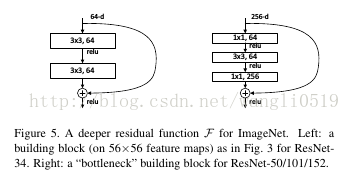

In [2]:
import tensorflow as tf
from tensorflow.keras import *

print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


In [27]:
class BasicBlock(layers.Layer):
    def __init__(self, filter_num, stride=1, **kwargs):
        self.layer_conv1 = layers.Conv2D(filters=filter_num, kernel_size=(3, 3), strides=stride, padding="same")
        self.layer_bn1 = layers.BatchNormalization()
        self.layer_conv2 = layers.Conv2D(filters=filter_num, kernel_size=(3, 3), strides=1, padding="same")
        self.layer_bn2 = layers.BatchNormalization()
        self.layer_relu = layers.Activation('relu')
        if stride != 1: # Size of main path and residual path are not matched
            self.layer_downsample = Sequential()
            self.layer_downsample.add(layers.Conv2D(filters=filter_num, kernel_size=(1, 1), strides=stride))
            self.layer_downsample.add(layers.BatchNormalization())
        else:
            self.layer_downsample = lambda x: x
        super().__init__(**kwargs)

    def call(self, inputs, training=None, **kwargs):
        residual = self.layer_downsample(inputs)

        x = self.layer_conv1(inputs)
        x = self.layer_bn1(x, training=training)
        x = self.layer_relu(x)
        x = self.layer_conv2(x)
        x = self.layer_bn2(x, training=training)
        x = self.layer_relu(layers.add([residual, x]))
        
        return x
    
class BottleNeck(layers.Layer):
    def __init__(self, filter_num, stride=1, **kwargs):
        self.layer_conv1 = layers.Conv2D(filters=filter_num, kernel_size=(1, 1), strides=1, padding='same')
        self.layer_bn1 = layers.BatchNormalization()
        self.layer_conv2 = layers.Conv2D(filters=filter_num, kernel_size=(3, 3), strides=stride, padding='same')
        self.layer_bn2 = layers.BatchNormalization()
        self.layer_conv3 = layers.Conv2D(filters=filter_num * 4, kernel_size=(1, 1), strides=1, padding='same')
        self.layer_bn3 = layers.BatchNormalization()
        self.layer_relu = layers.Activation('relu')
        self.layer_downsample = Sequential()
        self.layer_downsample.add(layers.Conv2D(filters=filter_num * 4, kernel_size=(1, 1), strides=stride))
        self.layer_downsample.add(layers.BatchNormalization())
        super().__init__(**kwargs)

    def call(self, inputs, training=None, **kwargs):
        residual = self.layer_downsample(inputs)
        x = self.layer_conv1(inputs)
        x = self.layer_bn1(x, training=training)
        x = self.layer_relu(x)
        x = self.layer_conv2(x)
        x = self.layer_bn2(x, training=training)
        x = self.layer_relu(x)
        x = self.layer_conv3(x)
        x = self.layer_bn3(x, training=training)
        x = self.layer_relu(layers.add([residual, x]))
        return x

class BasicBlocks(layers.Layer):
    def __init__(self, filter_num, blocks, stride=1, **kwargs):
        self.layer_res_block = Sequential()
        for i in range(blocks):
            self.layer_res_block.add(BasicBlock(filter_num, stride=(stride if i==0 else 1)))
        super().__init__(**kwargs)

    def call(self, inputs, training=None, **kwargs):
        return self.layer_res_block(inputs)
    
class BottleNecks(layers.Layer):
    def __init__(self, filter_num, blocks, stride=1, **kwargs):
        self.layer_res_block = Sequential()
        for i in range(blocks):
            self.layer_res_block.add(BottleNeck(filter_num, stride=(stride if i==0 else 1)))
        super().__init__(**kwargs)

    def call(self, inputs, training=None, **kwargs):
        return self.layer_res_block(inputs)


    
def ResNetTypeI(input_shape, layer_params, num_classes=10, name = ''):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding="same", name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Activation('relu', name='relu1')(x)
    x = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same", name='maxpool1')(x)
    x = BasicBlocks(filter_num=64, blocks=layer_params[0], name='BasicBlocks1')(x)
    x = BasicBlocks(filter_num=128, blocks=layer_params[1], stride=2, name='BasicBlocks2')(x)
    x = BasicBlocks(filter_num=256, blocks=layer_params[2], stride=2, name='BasicBlocks3')(x)
    x = BasicBlocks(filter_num=512, blocks=layer_params[3], stride=2, name='BasicBlocks4')(x)
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(units=num_classes, activation=activations.softmax, name='fc')(x)
    
    return Model(inputs, x, name=name)


def ResNetTypeII(input_shape, layer_params, num_classes=10, name = ''):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding="same", name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Activation('relu', name='relu1')(x)
    x = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same", name='maxpool1')(x)
    x = BottleNecks(filter_num=64, blocks=layer_params[0], name='BottleNecks1')(x)
    x = BottleNecks(filter_num=128, blocks=layer_params[1], stride=2, name='BottleNecks2')(x)
    x = BottleNecks(filter_num=256, blocks=layer_params[2], stride=2, name='BottleNecks3')(x)
    x = BottleNecks(filter_num=512, blocks=layer_params[3], stride=2, name='BottleNecks4')(x)
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(units=num_classes, activation=activations.softmax, name='fc')(x)
    
    return Model(inputs, x, name=name)


def resnet_18():
    return ResNetTypeI((256, 256, 3), layer_params=[2, 2, 2, 2], num_classes=1000, name='resnet18')

def resnet_34():
    return ResNetTypeI((256, 256, 3), layer_params=[3, 4, 6, 3], num_classes=1000, name='resnet34')

def resnet_50():
    return ResNetTypeII((256, 256, 3), layer_params=[3, 4, 6, 3], num_classes=1000, name='resnet50')

def resnet_101():
    return ResNetTypeII((256, 256, 3), layer_params=[3, 4, 23, 3], num_classes=1000, name='resnet101')

def resnet_152():
    return ResNetTypeII((256, 256, 3), layer_params=[3, 8, 36, 3], num_classes=1000, name='resnet152')

In [30]:
resnet_18().summary()

Model: "resnet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 64)      9472      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 128, 128, 64)      256       
_________________________________________________________________
relu1 (Activation)           (None, 128, 128, 64)      0         
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 64, 64, 64)        0         
_________________________________________________________________
BasicBlocks1 (BasicBlocks)   (None, 64, 64, 64)        148736    
_________________________________________________________________
BasicBlocks2 (BasicBlocks)   (None, 32, 32, 128)       527